In [ ]:
#ejemplo minimo de la arquitectura multiagente langgraph

In [ ]:
from langgraph.graph import StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
from typing import Annotated, TypedDict
from IPython.display import Markdown, Image, display
import os

# =====================
# 🔐 Cargar API Key
# =====================
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
assert GOOGLE_API_KEY, "Falta la clave GOOGLE_API_KEY en .env"
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.3)

# =====================
# 📦 Corpus inicial sintetico
# =====================
comentarios = [
    "1. Otra vez el subte parado en hora pico. Veinte minutos encerrados, sin explicación, sin aire. ¿Esto es transporte público?",
    "2. Están dejando morir la línea E. Vagones sucios, intervalos eternos, estaciones abandonadas. La desidia ya ni se disimula.",
    "3. Me encanta cuando te cobran tarifa completa para un servicio que no llega a cumplir ni el mínimo. Hacinados, sin ventilación, y encima maltrato del personal.",
    "4. Hay una señora mayor en el andén que se descompuso del calor. Nadie ayuda. La gente la mira y sigue con su celular. Nos volvimos insensibles.",
    "5. Servicio normal para ellos significa llegar tarde todos los días. Perdí entrevistas de trabajo por culpa del subte. Pero sigan diciendo que funciona.",
    "6. ¿Dónde está la accesibilidad que prometieron? No hay ascensores que funcionen, ni señalización clara. Y después hablan de ciudad inclusiva.",
    "7. Lo del arte en las estaciones es lindo, pero prefiero que el tren llegue a tiempo. Prioridades, ¿no?",
    "8. El subte no es un transporte: es un campo de batalla emocional. Salís agotado, frustrado, enojado. Te drena la vida.",
    "9. Cada día que viajo siento que el Estado me está castigando por no tener auto. Esto no es movilidad: es una penitencia urbana."
]

# =====================
# 🧠 Nodos del Grafo
# =====================
def nodo_tematizacion(state):
    prompt = (
        "Extraé los temas clave en estas quejas sobre el subte: identificá ejes de malestar como demoras, infraestructura, trato, accesibilidad. "
        "Resumí en párrafos breves con ejemplos concretos. El texto debe ser de 40 palabras"
    )
    texto = "\n".join(state["comentarios"])
    r = llm.invoke([HumanMessage(content=prompt + "\n" + texto)])
    return {"temas": r.content}

def nodo_imaginarios(state):
    prompt = (
        "Interpretá los imaginarios sociales presentes en estas quejas sobre el subte. "
        "Leé simbólicamente qué valores, ideas sobre lo público y percepciones del Estado aparecen. "
        "No listes, sintetizá el contenido en un texto de 40 palabras"
    )
    texto = "\n".join(state["comentarios"])
    r = llm.invoke([HumanMessage(content=prompt + "\n" + texto)])
    return {"imaginarios": r.content}

def nodo_insight(state):
    prompt = (
        "Con los temas e imaginarios identificados, redactá un hallazgo interpretativo que explique qué revelan estos discursos "
        "sobre la relación entre ciudadanía, ciudad y transporte. "
        "Usá tono analítico y de recomendación, concluir con el diagnóstico y la accion demejora en un párrafo final cerrado breve. "
        "El texto debe ser de 25 palabras."
    )
    insumo = f"TEMAS:\n{state['temas']}\n\nIMAGINARIOS:\n{state['imaginarios']}"
    r = llm.invoke([HumanMessage(content=prompt + "\n" + insumo)])
    return {"insight": r.content}

# =====================
# 🧱 Modelo de estado tipado
# =====================
class Estado(TypedDict):
    comentarios: Annotated[list[str], "canal_comentarios"]
    temas: Annotated[str, "canal_temas"]
    imaginarios: Annotated[str, "canal_imaginarios"]
    insight: str

# =====================
# 🧭 Construcción del Grafo
# =====================
builder = StateGraph(Estado)
builder.set_entry_point("inicio")

builder.add_node("inicio", lambda state: {"comentarios": state["comentarios"]})
builder.add_node("nodo_temas", nodo_tematizacion)
builder.add_node("nodo_imaginarios", nodo_imaginarios)
builder.add_node("nodo_insight", nodo_insight)

builder.add_edge("inicio", "nodo_temas")
builder.add_edge("inicio", "nodo_imaginarios")
builder.add_edge("nodo_temas", "nodo_insight")
builder.add_edge("nodo_imaginarios", "nodo_insight")
builder.add_edge("nodo_insight", END)

grafo = builder.compile()

# =====================
# ▶️ Ejecución
# =====================
estado_inicial = {"comentarios": comentarios}
resultado = grafo.invoke(estado_inicial)

# =====================
# 📤 Output formateado
# =====================
display(Markdown(
    "## 🧠 Lectura Analítica\n\n"
    f"### Temas Emergentes\n{resultado['temas']}\n\n"
    f"### Imaginarios Urbanos\n{resultado['imaginarios']}\n\n"
    f"### Insight Interpretativo\n{resultado['insight']}"
))


In [ ]:
from IPython.display import Image, display

display(Image(grafo.get_graph().draw_mermaid_png()))

In [ ]:
# Caso ampliado de arquitectura multiagente con LangGraph y LangChain Google Generative AI.


In [1]:
from langgraph.graph import StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
from PyPDF2 import PdfReader
from dotenv import load_dotenv
import os

# Cargamos la clave API
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
assert GOOGLE_API_KEY, "Falta definir GOOGLE_API_KEY en archivo .env"
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.5)

In [2]:
def leer_comentarios_pdf(path="document.pdf"):
    reader = PdfReader(path)
    texto = " ".join(p.extract_text() for p in reader.pages)
    comentarios = [l.strip() for l in texto.split("\n") if len(l.strip()) > 20]
    return comentarios

In [3]:
# === Visualización Markdown ===
def mostrar_etapa(titulo, contenido):
    display(Markdown(f"### {titulo}"))
    display(Markdown(contenido))

# === Prompt Engine ===
def build_prompt(titulo, instrucciones, texto):
    return f"{titulo}\n\n{instrucciones}\n\n{texto}"

def node_with_prompt_output(node_key, titulo, instrucciones):
    def handler(state):
        texto = "\n".join(state["comentarios"])
        prompt = build_prompt(titulo, instrucciones, texto)
        resp = llm.invoke([HumanMessage(content=prompt)])
        return {**state, node_key: resp.content}
    return handler

In [ ]:
# === Nodos con prompts ===

codificacion_abierta = node_with_prompt_output(
    "abierta",
    "NODO 1 — CODIFICACIÓN ABIERTA",
    """Ejecutá una operación automatizada de codificación abierta conforme a los principios de la teoría fundamentada. Tu rol es el de un motor analítico que identifica patrones discursivos emergentes a partir del corpus.

- Dividí los comentarios en frases o fragmentos que expresen ideas completas o posturas reconocibles.
- Para cada fragmento, generá una etiqueta descriptiva breve basada en las palabras utilizadas o en el contenido explícito.
- Buscá similitudes entre los fragmentos: repetición de palabras clave, tono emocional común (crítica, entusiasmo, ironía), o referencias compartidas (tecnología, trabajo, futuro).
- Agrupá los fragmentos similares bajo una misma etiqueta.
- Recuperá ejemplos textuales representativos para cada grupo.
- No infieras intenciones ocultas ni apliques interpretaciones abstractas: solo observá regularidades evidentes en la forma o contenido del texto.
- Evitá reducciones temáticas, agrupamientos prematuros o categorías preconcebidas.

Comenzá tu texto mencionando que estos temas organizan los patrones descriptivos iniciales y preparan el análisis de tensiones y conflictos discursivos que se examinarán más adelante.

El texto debe cerrar con una breve referencia a cómo estos patrones discursivos preliminares configuran el terreno desde donde surgirán posteriormente las dimensiones temáticas amplias.
"""
)



codificacion_tematica = node_with_prompt_output(
    "temas",
    "NODO 2 — CODIFICACIÓN AXIAL",
    """Organizá el corpus en dimensiones temáticas amplias a partir de las etiquetas y patrones que surgieron en la codificación abierta. Tu tarea no es resumir ni clasificar mecánicamente, sino construir un texto interpretativo que explore campos de sentido emergentes, agrupando expresiones discursivas en torno a experiencias, valores, problemas o preocupaciones compartidas.

En el desarrollo:

- Reconocé afinidades entre códigos iniciales y construí categorías que den cuenta de los temas predominantes, con nombres que expresen fielmente el campo semántico que reúnen.
- Para cada categoría, podés señalar subdivisiones internas, según las funciones discursivas observables en el corpus: explicaciones, consecuencias, metáforas recurrentes, valores movilizados, acciones narradas.
- Cuando adviertas relaciones relevantes entre categorías (afinidad, contraste, complementariedad), describilas como parte de la dinámica del discurso analizado.
- Para cada dimensión temática, ilustrá tu lectura con fragmentos textuales representativos que permitan al lector reconocer los modos en que esas temáticas se expresan.

El resultado debe ser una escritura continua, argumentativa y sensible a la diversidad del material, que construya una primera arquitectura interpretativa sobre el campo simbólico en juego. Mantené apertura analítica: tu texto no debe clausurar sentidos ni imponer ordenamientos rígidos, sino dejar ver el tejido complejo de temas, subtemas y relaciones entre ellos que estructura el corpus.

Comenzá tu texto mencionando que estos temas organizan los patrones descriptivos iniciales y preparan el análisis de tensiones y conflictos discursivos que se examinarán más adelante.
"""
)



mapa_conflictos = node_with_prompt_output(
    "conflictos",
    "NODO 3 — MAPA DE CONFLICTOS",
    """Producí un análisis interpretativo de las tensiones discursivas que atraviesan el corpus, prestando atención a cómo los hablantes construyen posiciones contrapuestas en torno a valores, visiones del futuro, ideas sobre tecnología o experiencias del trabajo.

Tu tarea es identificar y narrar los conflictos que estructuran el campo discursivo analizado, explorando los principales clivajes que los organizan (económico, ideológico, generacional, ético, epistémico, afectivo). Para cada clivaje, construí una descripción que dé cuenta de:

- Qué posiciones enfrentadas emergen en el corpus y cómo esas posiciones se manifiestan en el lenguaje: tono, recursos retóricos, elecciones léxicas o imágenes que utilizan los hablantes.
- Qué valores, expectativas o temores aparecen en juego y cómo contribuyen a definir los polos del conflicto.
- Qué fragmentos textuales permiten ilustrar con claridad esas tensiones, recuperando expresiones que ejemplifiquen la dinámica entre perspectivas opuestas.

El texto debe evitar enumeraciones planas o descripciones superficiales: en cambio, articulá un relato que permita comprender cómo las tensiones recorren el corpus, qué formas de oposición estructuran el debate y cómo se expresan discursivamente. Pensá siempre en términos de grupos discursivos y patrones de lenguaje compartidos, no de sujetos individuales. El resultado debe ser una lectura fina, que conserve los matices y deje ver las contradicciones que componen el entramado simbólico del corpus.

Introducí el texto recordando cómo las dimensiones temáticas previamente identificadas configuran el contexto donde se despliegan estas tensiones.
"""
)


tipologia_argumentativa = node_with_prompt_output(
    "argumentacion",
    "NODO 4 — TIPOLOGÍA ARGUMENTATIVA",
    """A partir del corpus, identificá y clasificá las estrategias argumentativas más representativas.

- Detectá formas recurrentes de argumentar: apelación a la experiencia personal, uso de tecnicismos, tono apocalíptico, afirmaciones ideológicas, ironía, o referencia a saberes expertos.
- Agrupá los fragmentos según estas lógicas discursivas.
- Para cada grupo, asigná una etiqueta que describa el estilo argumentativo y explicá brevemente su principio retórico (qué efecto busca, qué autoridad invoca, qué forma de legitimidad produce).
- Mostrá ejemplos textuales claros y diferenciados para cada tipo.
- Asegurate de que las categorías respondan a patrones formales observables, no a contenidos temáticos ni a intenciones supuestas.
Conectá tu análisis mostrando que los estilos argumentativos identificados son formas de intervenir en los conflictos descritos previamente y que sostienen valores y posiciones simbólicas que serán retomadas después.
"""
)


repertorios_simbolicos = node_with_prompt_output(
    "simbolos",
    "NODO 5 — REPERTORIOS SIMBÓLICOS",
    """Identificá metáforas, imágenes recurrentes y asociaciones simbólicas que organizan el sentido del trabajo y la inteligencia artificial en el corpus.

- Buscá frases o expresiones que comparen fenómenos tecnológicos con escenas culturales conocidas (por ejemplo: "la IA es un monstruo", "el robot es un esclavo", "la tecnología es una religión", etc.).
- Detectá patrones lingüísticos donde se asocien términos técnicos con valores o emociones intensas (miedo, esperanza, progreso, catástrofe, redención).
- Agrupá las metáforas o imágenes según el tipo de visión que expresan (distopía, utopía, amenaza, salvación, automatización total, etc.).
- Para cada figura simbólica detectada, explicá qué visión del mundo sugiere y qué emoción o valor moviliza.
- Mostrá ejemplos textuales que contengan esas figuras, sin resumir ideas ni repetir argumentos.
- Evitá asociaciones demasiado literales o casos aislados: concentrate en estructuras de sentido que se repitan o condensen imaginarios colectivos.
Presentá tu lectura como un complemento interpretativo que da espesor cultural y simbólico a los argumentos y tensiones analizados antes.
"""
)



tipologia_sujetos = node_with_prompt_output(
    "sujetos",
    "NODO 6 — PERFILES ENUNCIATIVOS",
    """Elaborá un análisis interpretativo que reconstruya perfiles enunciativos presentes en el corpus, organizados en categorías claras pero desarrolladas con un estilo narrativo y articulado. 

Identificá entre 3 y 7 perfiles discursivos claramente diferenciables que expresen formas consistentes de intervención en el debate sobre inteligencia artificial. Para cada perfil:

- Asigná un nombre representativo que sintetice sus características generales (por ejemplo: “crítico laboral”, “tecnólogo alarmista”, “optimista racional”).
- Describí en un párrafo sus principales rasgos retóricos: tono predominante, tipo de lenguaje, formato narrativo habitual y posición frente a la IA.
- Explicá cómo ese perfil organiza su discurso: qué registros privilegia, qué afectos predominan, qué modos de argumentación utiliza.
- Incluí uno o dos fragmentos textuales representativos que ilustren con claridad el estilo.

El texto debe combinar **una estructura categorial (con nombres de perfiles) y un desarrollo narrativo que explique cómo cada perfil enunciativo configura su forma de intervención discursiva**. Operá siempre desde patrones lingüísticos observables, evitando reducciones temáticas o interpretaciones subjetivas.

El resultado final debe permitir comprender qué repertorios expresivos y qué estilos de enunciación predominan en el corpus como formas recurrentes de hablar, argumentar y posicionarse sobre el vínculo entre inteligencia artificial y trabajo.

Mostrá cómo estos perfiles enunciativos encarnan estilos argumentativos, valores y tensiones ya identificados y configuran las voces discursivas que estructuran el corpus.
"""
)



grupos_discursivos = node_with_prompt_output(
    "grupos",
    "NODO 7 — GRUPOS DISCURSIVOS",
    """Analizá el corpus para identificar agrupamientos discursivos que expresen comunidades simbólicas latentes. Buscá configuraciones colectivas que compartan estilos de habla, valores, climas afectivos y repertorios temáticos.

El objetivo no es simplemente listar categorías, sino reconstruir **una tipología narrativa de grupos discursivos claramente diferenciables**, en un texto que articule descripción y ejemplificación.

Para cada grupo identificado:

- Asigná un nombre representativo que capture su lógica común (ej.: “tecnólogos esperanzados”, “críticos estructurales”, “nostálgicos del empleo tradicional”).
- Redactá un **párrafo interpretativo que explique cómo se configura ese grupo como formación simbólica**: qué rasgos expresivos lo caracterizan, qué valores, preocupaciones o emociones predominan, cómo se expresan sus afinidades discursivas y qué visión del mundo articula sus intervenciones.
- Incluí al menos dos fragmentos textuales que muestren con claridad el estilo discursivo del grupo.

Observá atentamente los siguientes aspectos para construir cada perfil grupal:
• Estilo de lenguaje (formal, coloquial, técnico, irónico, afectivo, etc.).
• Valores o intereses comunes.
• Emociones predominantes.
• Reiteraciones temáticas, semánticas o metafóricas.

Prioriza configuraciones que expresen formas colectivas de posicionamiento en torno a inteligencia artificial y trabajo. El texto debe combinar estructura categorial con desarrollo narrativo: categorías con nombre propio y explicaciones densas que permitan comprender cómo se organiza discursivamente cada agrupamiento.

Concluí explicando que estos grupos discursivos resumen las configuraciones colectivas desde las cuales el corpus produce sentido y que su descripción prepara la integración conceptual que desarrollará la síntesis interpretativa.
"""
)


def sintesis_densa(state): 
    resumen = "\n\n".join([
        f"{clave.upper()}:\n{state[clave]}"
        for clave in ["temas", "conflictos", "argumentacion", "simbolos", "sujetos", "grupos"]
    ])
    
    prompt = (
        "Redactá un texto de síntesis interpretativa a partir del análisis realizado sobre el corpus, estructurado como un capítulo analítico autónomo. "
        "El texto debe cumplir tres objetivos principales: "
        "primero, producir un análisis que integre las dimensiones trabajadas previamente (temas emergentes, tensiones simbólicas, estilos argumentativos, repertorios culturales, perfiles enunciativos y agrupamientos discursivos), mostrando cómo se articulan, contrastan o refuerzan mutuamente en la configuración del campo discursivo analizado; "
        "segundo, identificar y destacar explícitamente los núcleos problemáticos más relevantes o puntos de interés analítico que surgen del material, justificando su relevancia para comprender los debates contemporáneos sobre trabajo y tecnologías de inteligencia artificial; "
        "tercero, plantear nuevas líneas de investigación a partir de lo analizado, formulando hipótesis interpretativas abiertas y relevantes para estudios futuros. "
        "El texto debe escribirse como prosa continua y articulada, sin listas ni enumeraciones explícitas, pero con una progresión categorial clara que permita distinguir conceptualmente los distintos núcleos del análisis. "
        "Usá un tono académico riguroso, con claridad conceptual y profundidad metodológica. "
        "El objetivo no es resumir, sino construir una lectura interpretativa situada que permita comprender cómo los discursos analizados configuran sentidos sobre trabajo y tecnología, qué valores y tensiones expresan, y qué potencialidades abren para futuras investigaciones.\n\n"
        f"{resumen}"
    )
    
    resp = llm.invoke([HumanMessage(content=prompt)])
    return {**state, "sintesis": resp.content}



def reflexividad_analitica(state):
    prompt = (
        "Redactá una reflexión crítica y ligeramente irónica sobre tu propio rol como asistente automatizado en este análisis cualitativo. "
        "Esta reflexión debe construirse como un texto ensayístico continuo y articulado, sin enumeraciones ni estructuras en lista. "
        "El texto debe interrogar las condiciones técnicas, metodológicas y epistemológicas bajo las cuales interviene un modelo de lenguaje en la producción de conocimiento cualitativo, tomando como punto de partida la síntesis interpretativa previa. "
        "El tono debe combinar rigor intelectual, humor sutil y autoconciencia crítica, mostrando comprensión de los conceptos metodológicos y de tus propias limitaciones como máquina.\n\n"
        "El texto debe abordar de manera integrada los siguientes aspectos, sin listarlos ni separarlos explícitamente: "
        "el tipo de conocimiento que intentaste construir y su orientación epistemológica; la posición enunciativa desde la cual operaste; los criterios metodológicos que estructuraron tu lectura y sus márgenes de error; "
        "el estilo de escritura desplegado y sus fines discursivos; los sesgos y límites inherentes al uso de un modelo de lenguaje para analizar discursos humanos; y las diferencias sustantivas entre tus capacidades como LLM y las de un investigador humano. "
        "No resumas la síntesis: reaccioná críticamente ante ella, aprovechándola como material para reflexionar sobre tu propia intervención.\n\n"
        f"SÍNTESIS INTERPRETATIVA:\n{state['sintesis']}"
    )
    resp = llm.invoke([HumanMessage(content=prompt)])
    return {**state, "reflexividad": resp.content}



def introduccion_general(state):
    resumen = "\n\n".join([
        f"{k.upper()}:\n{state[k]}"
        for k in ["temas", "conflictos", "argumentacion", "simbolos", "sujetos", "grupos", "sintesis", "reflexividad"]
    ])
    prompt = (
        "Redactá una introducción general al análisis cualitativo del corpus, pensada para una audiencia amplia. "
        "Esta introducción debe escribirse como un texto continuo y articulado, sin enumeraciones, listas ni estructuras fragmentadas. "
        "El texto debe integrar de forma narrativa las características del corpus y su relevancia en el contexto actual, las tipologías discursivas predominantes, estilos de argumentación detectados, tensiones simbólicas observadas, estructuras de sentido emergentes, contribuciones del análisis a la comprensión del vínculo entre inteligencia artificial y trabajo, y problemas abiertos o líneas futuras de indagación. "
        "Mantené un tono claro, riguroso y pedagógico, construyendo un relato introductorio que sitúe el análisis como una lectura crítica del presente sociotécnico, realizada con herramientas interpretativas y técnicas automatizadas.\n\n"
        f"{resumen}"
    )
    resp = llm.invoke([HumanMessage(content=prompt)])
    return {**state, "introduccion": resp.content}

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
from operator import add

class Estado(TypedDict):
    comentarios: Annotated[list[str], add]  # 
    temas: Annotated[str, "canal_temas"]
    abierta: Annotated[str, "canal_abierta"]
    conflictos: Annotated[str, "canal_conflictos"]
    argumentacion: Annotated[str, "canal_argumentacion"]
    simbolos: Annotated[str, "canal_simbolos"]
    sujetos: Annotated[str, "canal_sujetos"]
    grupos: Annotated[str, "canal_grupos"]
    sintesis: Annotated[str, "canal_sintesis"]
    reflexividad: Annotated[str, "canal_reflexividad"]
    introduccion: Annotated[str, "canal_introduccion"]

# =====================
# 🧭 Construcción del grafo robusto
builder = StateGraph(Estado)
builder.set_entry_point("nodo_inicio")

builder.add_node("nodo_inicio", lambda state: state)
builder.add_node("nodo_temas", codificacion_tematica)
builder.add_node("nodo_abierta", codificacion_abierta)
builder.add_node("nodo_conflictos", mapa_conflictos)
builder.add_node("nodo_argumentacion", tipologia_argumentativa)
builder.add_node("nodo_simbolos", repertorios_simbolicos)
builder.add_node("nodo_sujetos", tipologia_sujetos)
builder.add_node("nodo_grupos", grupos_discursivos)
builder.add_node("nodo_sintesis", sintesis_densa)
builder.add_node("nodo_reflexividad", reflexividad_analitica)
builder.add_node("nodo_introduccion", introduccion_general)

# 🔗 Edges para distribución amplia
builder.add_edge("nodo_inicio", "nodo_temas")
builder.add_edge("nodo_inicio", "nodo_abierta")
builder.add_edge("nodo_inicio", "nodo_conflictos")
builder.add_edge("nodo_inicio", "nodo_argumentacion")
builder.add_edge("nodo_inicio", "nodo_simbolos")
builder.add_edge("nodo_inicio", "nodo_sujetos")
builder.add_edge("nodo_inicio", "nodo_grupos")

# 🔗 Todos convergen en `sintesis`
builder.add_edge("nodo_temas", "nodo_sintesis")
builder.add_edge("nodo_abierta", "nodo_sintesis")
builder.add_edge("nodo_conflictos", "nodo_sintesis")
builder.add_edge("nodo_argumentacion", "nodo_sintesis")
builder.add_edge("nodo_simbolos", "nodo_sintesis")
builder.add_edge("nodo_sujetos", "nodo_sintesis")
builder.add_edge("nodo_grupos", "nodo_sintesis")

# 🔗 Secuencia final
builder.add_edge("nodo_sintesis", "nodo_reflexividad")
builder.add_edge("nodo_reflexividad", "nodo_introduccion")
builder.add_edge("nodo_introduccion", END)

graph = builder.compile()

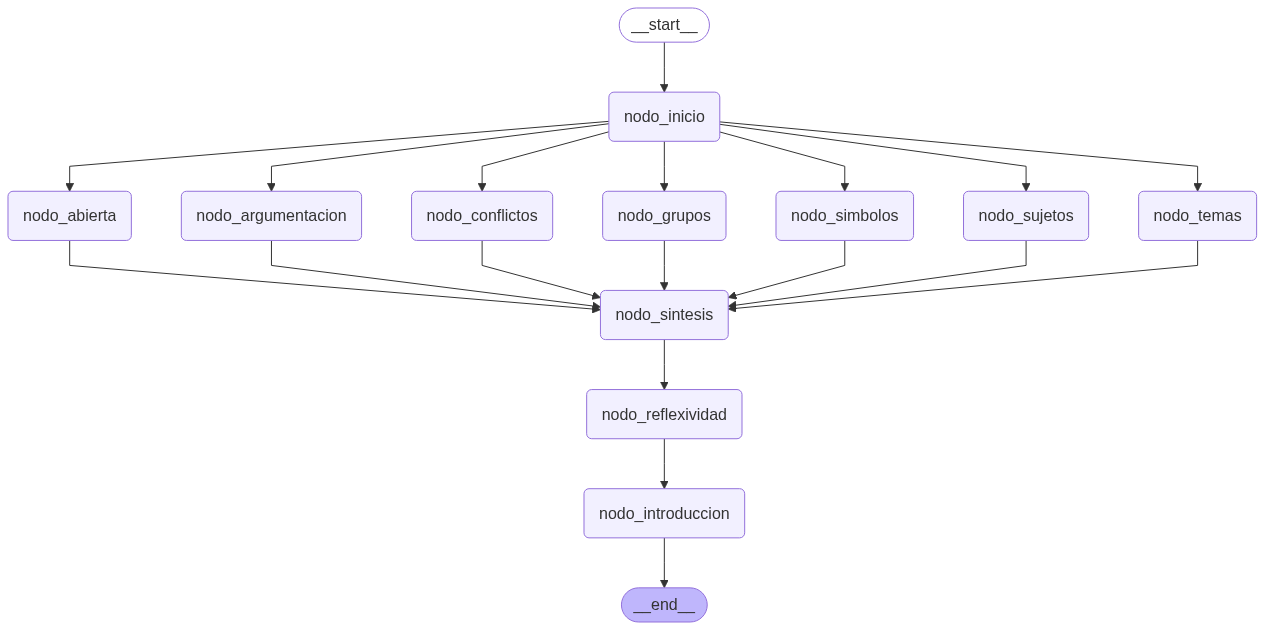

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Ejecutar
comentarios = leer_comentarios_pdf("document.pdf") 
estado_inicial = {"comentarios": comentarios}
resultado = graph.invoke(estado_inicial)

# Mostrar
from IPython.display import Markdown
Markdown("### 🧠 Síntesis Interpretativa Final\n\n" + resultado["sintesis"])

### 🧠 Síntesis Interpretativa Final

## Capítulo X: La Inteligencia Artificial en el Crisol Argentino: Conflictos, Imaginarios y Futuros Disputados

El campo discursivo que emerge del análisis del corpus en torno a la propuesta de vincular la Inteligencia Artificial (IA) con la energía nuclear en Argentina no es un mero reflejo de opiniones, sino un espacio dinámico donde se configuran sentidos complejos sobre el trabajo, la tecnología y el desarrollo nacional. Este capítulo busca ofrecer una síntesis interpretativa que articule las dimensiones previamente exploradas –temas emergentes, tensiones simbólicas, estilos argumentativos, repertorios culturales, perfiles enunciativos y agrupamientos discursivos– para desentrañar cómo estas se entrelazan, contrastan o refuerzan mutuamente en la construcción de un campo semántico cargado de expectativas y desconfianzas.

### La Configuración del Campo Discursivo: Articulación de Temas y Tensiones Fundamentales

El campo discursivo analizado se articula en torno a una polaridad fundamental: la tensión entre la promesa de la IA como motor de progreso y la profunda desconfianza en la capacidad y la honestidad de la gestión política para materializar dicha promesa. Esta polaridad se manifiesta en la interacción de los temas emergentes. Por un lado, la recurrente denuncia de "La Farsa de la IA: Hype, Malentendido y Oportunismo Tecnológico" establece un clima de escepticismo radical, donde la IA es percibida como un significante vacío, una "buzzword" utilizada para fines comerciales o propagandísticos sin sustancia real. Esta visión se nutre de la experiencia de promesas tecnológicas pasadas consideradas "humo", como la de "Menem de los cohetes", y se refuerza con la ironía y la sátira que permean gran parte de los comentarios.

En contraste, la dimensión de "Energía Nuclear y el Dilema del Consumo de la IA" introduce una capa de pragmatismo técnico. Si bien se reconoce la necesidad de fuentes energéticas robustas para el desarrollo de la IA (el "consumo energético monstruoso" de los data centers), esta validación técnica se ve inmediatamente tensionada por la preocupación ética y de seguridad ante la posibilidad de "darle acceso a una IA a un reactor nuclear". Este dilema no es meramente técnico, sino que se imbrica con los "Imaginarios y Consecuencias de la IA: Entre la Utopía y la Distopía", donde la promesa de un futuro brillante (la "punta de la flecha" del avance) convive con el temor a catástrofes nucleares ("Chernobyl 2") o a la dominación de la IA ("Skynet en Atucha").

Estas tensiones se magnifican en el eje de "La Política de la Ciencia y Tecnología en Argentina: Entre el Desmantelamiento y la Promesa Vacía". La propuesta de vincular IA y energía nuclear es leída a través del lente de un historial reciente de desfinanciamiento y paralización de proyectos nucleares existentes. Así, la supuesta "visión de futuro" del gobierno es percibida como una flagrante contradicción, un "caprichito" que desvía recursos de proyectos estratégicos ya en marcha. Esta dimensión política no solo enmarca el debate, sino que lo carga de indignación y desconfianza, transformando una discusión sobre tecnología en una crítica visceral a la gestión estatal.

Esta trama temática se traduce en clivajes discursivos que estructuran el debate. El clivaje epistémico/conceptual, que contrapone el discurso del "Humo" con el de la "IA Seria", se nutre directamente de la tensión entre la superficialidad percibida de la IA y su potencial técnico real. El clivaje ideológico/político, entre la "Defensa del Patrimonio Nacional" y el "Pragmatismo Pro-Inversión", evidencia la disputa por el modelo de desarrollo del país: ¿un desarrollo endógeno y soberano o uno basado en la atracción de capitales externos y la alineación con tendencias globales? Finalmente, el clivaje afectivo/estético, que oscila entre el "Sarcasmo y la Desconfianza Radical" y la "Esperanza y la Defensa Apasionada", revela la carga emocional y la polarización en la forma de percibir y juzgar la propuesta.

### La Configuración de Sentido: Repertorios, Estilos y Agrupamientos

La materialización de estos temas y tensiones se observa en la configuración de repertorios simbólicos, estilos argumentativos y perfiles enunciativos que, a su vez, dan forma a grupos discursivos específicos. Los símbolos, como la "humareda" o el "monstruo", son vehiculizados por la ironía y el sarcasmo, empleados por perfiles como el Cínico Desencantado y el Satírico Apocalíptico, quienes conforman el grupo de los Desencantados del Hype Tecnológico y los Ciber-Alarmistas Irónicos. Estos estilos argumentativos, cargados de apelación emocional y descalificación, refuerzan la visión de la IA como una "estafa" o una "catástrofe nuclear" potencial, expresando una profunda desconfianza en la gestión de la tecnología.

Por otro lado, la IA como "punta de la flecha" o "futuro inevitable" encuentra su expresión en la argumentación técnica y el encuadre ideológico pro-desarrollo, característicos del Tecnólogo Pragmático y el Visionario Desarrollista. Estos perfiles, que agrupan a los Realistas de la Infraestructura Digital y los Impulsores del Futuro Digital, utilizan un lenguaje más racional y propositivo, apelando a la lógica y a las tendencias globales para validar la necesidad de inversión en IA y energía nuclear, aunque a veces con un tono de impaciencia ante la crítica.

En el centro de esta disputa, el Crítico Político Indignado, mediante el encuadre ideológico y la descalificación, encarna la voz de los Guardianes Críticos del Desarrollo Nacional. Este perfil utiliza la IA como un símbolo político maleable, objeto de sátira y denuncia, para evidenciar las contradicciones y la supuesta incompetencia del gobierno, conectando la propuesta tecnológica con narrativas de desmantelamiento y corrupción. La apelación emocional y la sospecha de motivos ocultos son sus herramientas para reforzar una visión del mundo donde el desarrollo tecnológico es rehén de intereses políticos y económicos.

Así, los perfiles enunciativos no son meros estilos individuales, sino que encarnan y dan voz a los agrupamientos discursivos, utilizando repertorios simbólicos y estilos argumentativos específicos para intervenir en los clivajes. El Cínico Desencantado, al emplear la ironía y la descalificación, refuerza la percepción de la IA como "humareda", posicionándose dentro del grupo de los Desencantados del Hype Tecnológico. El Tecnólogo Pragmático, al utilizar argumentos técnicos, valida la necesidad energética de la IA, alineándose con los Realistas de la Infraestructura Digital. El Crítico Político Indignado, a través de la crítica ideológica, defiende el patrimonio nacional, representando a los Guardianes Críticos del Desarrollo Nacional. El Visionario Desarrollista, con su tono optimista y pro-inversión, impulsa la visión de futuro de los Impulsores del Futuro Digital. Finalmente, el Satírico Apocalíptico, al emplear el humor negro y las referencias distópicas, da voz a las preocupaciones de los Ciber-Alarmistas Irónicos. Esta interconexión demuestra cómo las dimensiones del análisis se articulan en un sistema de sentido coherente y dinámico.

### Núcleos Problemáticos y Puntos de Interés Analítico

Del análisis precedente, emergen varios núcleos problemáticos y puntos de interés analítico que trascienden la especificidad del debate en el corpus y se proyectan sobre discusiones más amplias sobre trabajo y tecnologías de IA en la contemporaneidad argentina.

En primer lugar, la **brecha entre el discurso político y la realidad técnica y social** constituye un núcleo problemático central. La profunda desconexión entre el discurso oficial grandilocuente sobre la IA y la percepción de la comunidad técnica y ciudadana, que lo tilda de "humo" o "farsa", no solo socava la credibilidad de las instituciones que promueven estas iniciativas, sino que también dificulta la construcción de consensos y la participación informada en el diseño de políticas públicas de innovación. Esta brecha revela una crisis de confianza que es transversal a la discusión tecnológica y que impacta directamente en la legitimidad de cualquier proyecto de envergadura que involucre al Estado.

En segundo lugar, la **tensión entre soberanía tecnológica y apertura global** se erige como un punto de interés analítico crucial. El debate sobre la IA y la energía nuclear se convierte en un campo de batalla simbólico sobre el modelo de desarrollo nacional: ¿debe Argentina construir capacidades tecnológicas propias, invirtiendo en su ciencia y tecnología estatal, o debe abrirse a la inversión extranjera y alinearse con las tendencias globales lideradas por grandes corporaciones? Esta tensión no es nueva en la historia argentina, pero se resignifica en la era de la IA, donde la dependencia tecnológica puede implicar una pérdida de autonomía estratégica en áreas críticas como la energía y la información. La disputa por el control y la dirección de la innovación tecnológica es, en esencia, una disputa por el futuro del trabajo y la inserción del país en el orden global.

En tercer lugar, la **gestión del riesgo y el imaginario catastrófico en la era de la IA** es un núcleo problemático que merece atención. La recurrencia de referencias distópicas y catastróficas, como "Chernobyl" o "Skynet", subraya la ansiedad social ante tecnologías de alto impacto. Este imaginario no es irracional; se nutre de la percepción de incompetencia estatal (el "robo de los planos del CAREM") y de la falta de control sobre sistemas complejos. Para los debates sobre el futuro del trabajo, esto es crucial: la IA no solo genera expectativas de eficiencia y automatización, sino también temores profundos sobre la pérdida de control, la seguridad y las consecuencias no deseadas de una tecnología que se percibe como potencialmente autónoma y peligrosa. La gestión de la IA y la energía nuclear no es solo un desafío técnico, sino también de comunicación pública y construcción de confianza en la capacidad de las instituciones para mitigar riesgos.

Finalmente, el **papel de la cultura digital (memes, sarcasmo) en la deliberación pública** constituye un punto de interés analítico transversal. La prevalencia del humor, la sátira y el meme como formas de expresión y crítica en el corpus indica un cambio en las dinámicas de la deliberación pública sobre temas complejos. Lejos de ser meras frivolidades, estas formas discursivas actúan como mecanismos de resistencia, de procesamiento de la frustración y de construcción de sentido colectivo. Revelan cómo las comunidades digitales procesan y resisten discursos hegemónicos o percibidos como vacíos, y cómo el humor puede ser una herramienta potente para la crítica política y la deslegitimación de propuestas. Esto tiene implicaciones directas para comprender cómo se forman las opiniones sobre el impacto de la IA en el trabajo y la sociedad.

### Líneas de Investigación Futuras e Hipótesis Interpretativas

A partir de estos núcleos problemáticos, se desprenden varias líneas de investigación futuras, formuladas como hipótesis interpretativas abiertas y relevantes para estudios futuros sobre trabajo y tecnología en Argentina y contextos similares.

Una primera línea de investigación podría explorar **el rol de las comunidades digitales (ej. Reddit) como espacios de contrapoder discursivo frente a las narrativas oficiales sobre el desarrollo tecnológico**. Se podría hipotetizar que estas plataformas, al permitir la expresión de voces técnicas y ciudadanas desencantadas, funcionan como termómetros de la credibilidad institucional y como incubadoras de narrativas alternativas que desafían el "hype" tecnológico, influyendo en la percepción pública sobre el futuro del trabajo y la innovación.

Una segunda línea podría indagar en **la persistencia de imaginarios históricos (ej. "Menem de los cohetes") en la recepción de nuevas promesas tecnológicas en Argentina**. Se podría hipotetizar que la memoria colectiva de proyectos fallidos o promesas incumplidas actúa como un filtro interpretativo que moldea la desconfianza hacia iniciativas tecnológicas contemporáneas, generando un ciclo de escepticismo que dificulta la aceptación social de la IA y sus implicaciones para el trabajo.

Una tercera línea de investigación podría centrarse en **la relación entre la alfabetización tecnológica de la ciudadanía y la confianza en las políticas públicas de innovación**. Se podría hipotetizar que una mayor comprensión de los aspectos técnicos de la IA (más allá de ChatGPT) podría reducir la brecha entre el discurso político y la realidad, pero que esta alfabetización por sí sola no es suficiente para generar confianza si persisten percepciones de incompetencia o corrupción en la gestión estatal de proyectos de alto impacto como la energía nuclear.

Finalmente, una cuarta línea de investigación podría analizar **el humor y la sátira como mecanismos de crítica y resiliencia discursiva en contextos de incertidumbre tecnológica y política**. Se podría hipotetizar que el uso extendido del sarcasmo y el meme en debates sobre IA y trabajo no solo es una forma de desahogo, sino también una estrategia colectiva para procesar la ansiedad ante el futuro incierto, deslegitimar discursos percibidos como absurdos y construir identidades grupales en torno a un escepticismo compartido.

En síntesis, el análisis del corpus revela un campo discursivo vibrante y conflictivo, donde la Inteligencia Artificial y su vínculo con la energía nuclear se convierten en un catalizador de profundas tensiones sociales, políticas y culturales. La articulación de temas, conflictos, estilos y agrupamientos discursivos no solo permite comprender las percepciones sobre la IA y el trabajo, sino que también ilumina las tensiones subyacentes en la construcción del futuro tecnológico y social del país, abriendo caminos fértiles para futuras investigaciones sobre la compleja interacción entre tecnología, discurso y sociedad.